In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import cv2 as cv
from PIL import Image
import glob

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

model = YOLO('runs/segment/train/weights/best.pt')
names = glob.glob('test/*.jpg')
predict_params = {"imgsz": 640, "conf": 0.3, "verbose": False, "device": "cpu", "max_det": 1}

In [6]:
img_root = names[2]

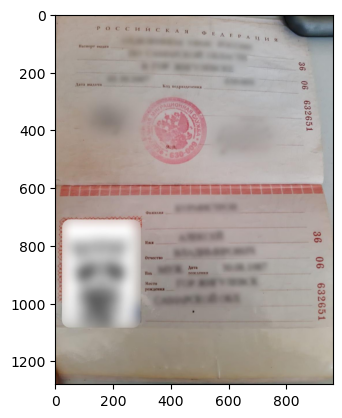

In [7]:
results = model(img_root, **predict_params)
annotated_frame = results[0].plot()
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_frame)
plt.show()

In [13]:
results[0].masks == None

True

In [8]:
results = model(img_root, **predict_params)

xy_result = results[0].masks.xy[0]

x_min, x_max, y_min, y_max = 10 ** 5, -1, 10 ** 5, -1
for x, y in xy_result:
    x_min = min(x_min, x)
    x_max = max(x_max, x)
    y_min = min(y_min, y)
    y_max = max(y_max, y)

mid = [int((x_min + x_max) / 2), int((y_min + y_max) / 2)]

xy_result_norm = xy_result.copy()
xy_result_norm -= mid

left_up, rigth_up, right_down, left_down = [0, 0], [0, 0], [0, 0], [0, 0]
for x, y in xy_result_norm:
    if x < 0 and y < 0 and abs(left_up[0]) + abs(left_up[1]) < abs(x) + abs(y):
        left_up = [x, y]
    elif x > 0 and y < 0 and abs(rigth_up[0]) + abs(rigth_up[1]) < abs(x) + abs(y):
        rigth_up = [x, y]
    elif x > 0 and y > 0 and abs(right_down[0]) + abs(right_down[1]) < abs(x) + abs(y):
        right_down = [x, y]
    elif x < 0 and y > 0 and abs(left_down[0]) + abs(left_down[1]) < abs(x) + abs(y):
        left_down = [x, y]
for i in range(2):
    left_up[i] = int(mid[i] + left_up[i])
    rigth_up[i] = int(mid[i] + rigth_up[i])
    right_down[i] = int(mid[i] + right_down[i])
    left_down[i] = int(mid[i] + left_down[i])

AttributeError: 'NoneType' object has no attribute 'xy'

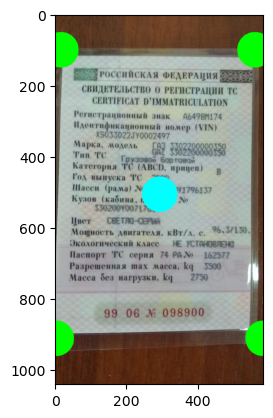

In [586]:
img = cv.imread(img_root)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
cv.circle(img, left_up, 50, (0, 255, 0), -1)
cv.circle(img, rigth_up, 50, (0, 255, 0), -1)
cv.circle(img, right_down, 50, (0, 255, 0), -1)
cv.circle(img, left_down, 50, (0, 255, 0), -1)

cv.circle(img, mid, 50, (0, 255, 255), -1)
plt.imshow(img)

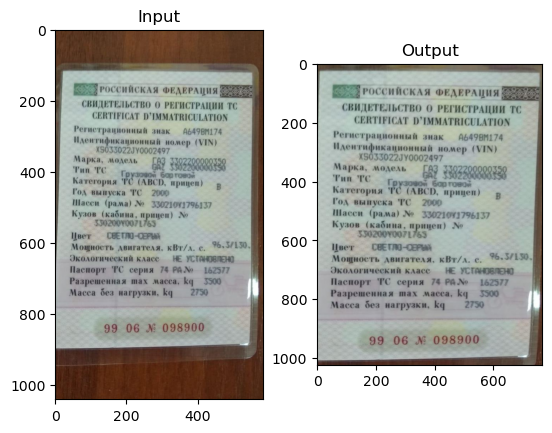

In [589]:
img = cv.imread(img_root)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

pts1 = np.float32([left_up, rigth_up, left_down, right_down])
if x_max - x_min > y_max - y_min:
    pts2 = np.float32([[0, 0], [size_max, 0], [0, int(size_max * 3 / 4)], [size_max, int(size_max * 3 / 4)]])
    M = cv.getPerspectiveTransform(pts1, pts2)
    dst = cv.warpPerspective(img, M, (size_max, int(size_max * 3 / 4)))
else:
    pts2 = np.float32([[0, 0], [int(size_max * 3 / 4), 0], [0, size_max], [int(size_max * 3 / 4), size_max]])
    M = cv.getPerspectiveTransform(pts1, pts2)
    dst = cv.warpPerspective(img, M, (int(size_max * 3 / 4), size_max))
    
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()